In [1]:
import numpy as np
import tskit
import msprime
from IPython.display import SVG
import tqdm, tsinfer
from scipy.optimize import least_squares
tskit.set_print_options(max_lines=100)

demography = msprime.Demography()
demography.add_population(name="Z", initial_size=10000)
demography.add_population(name="A", initial_size=10000)
demography.add_population(name="B", initial_size=10000)
demography.add_population(name="C", initial_size=10000)
demography.add_population(name="D", initial_size=10000)
demography.add_admixture(time=150, derived="C", ancestral=["A", "B"], proportions=[0.5, 0.5])
demography.add_admixture(time=150, derived="D", ancestral=["A", "B"], proportions=[0.25, 0.75])
demography.add_population_split(time=1050, derived=["A", "B"], ancestral="Z")
a_size = 20
b_size = 20
ab_size = a_size+b_size
bincount = 10

def gethalves(distr):
    dlen = len(distr)
    lefthalf = distr[:dlen//2]
    righthalf = distr[dlen//2:]
    print (np.sum(lefthalf), ":", np.sum(righthalf))

def dictto2d(dct, orderedsites):    
    lst2 = [dct[key] for key in orderedsites]        
    values = np.array(lst2)
    return values

def collectbin(array, binsize):
    size = array.size
    newsize = size//binsize
    array = array.reshape(newsize, binsize)    
    return array.sum(axis=1)

def representation(coef, adistr, bdistr, cdistr):
    diff = cdistr - coef*adistr - (1-coef)*bdistr
    #diff2 = diff * diff
    #return np.sum(diff2)
    return diff

def gettrueAfraction(mts, nodeid, migrsource):
    Aweight = 0
    Bweight = 0
    for migr in mts.tables.migrations:    
        if (migr.node == nodeid) and (migr.source == migrsource):
            if migr.dest == 1:
                Aweight += migr.right-migr.left 
            elif migr.dest == 2:
                Bweight += migr.right-migr.left
            else:
                assert(False)
    return (Aweight/(Aweight+Bweight))



def simulation(seed1, seed2):
    ts = msprime.sim_ancestry(samples=[msprime.SampleSet(a_size, ploidy=1, population='A'),
                                   msprime.SampleSet(b_size, ploidy=1, population='B'),
                                   msprime.SampleSet(1, ploidy=1, population='C'),
                                   msprime.SampleSet(1, ploidy=1, population='D')
                                  ],
                          record_migrations=True,
                          #record_full_arg=True, 
                          demography=demography, sequence_length=3*10**7, recombination_rate=1.69*10**-9, random_seed=seed1)
    mts = msprime.sim_mutations(ts, rate=1.25*10**-8, random_seed=seed2)
    
    with tsinfer.SampleData(
        path="./simulation.samples", sequence_length=mts.sequence_length, num_flush_threads=2
        ) as sample_data:
        for var in mts.variants():
            sample_data.add_site(var.site.position, var.genotypes, var.alleles)
            
    inferred_ts = tsinfer.infer(sample_data, recombination_rate=1.69*10**-9)
    
    ancestors=set()
    for tree in inferred_ts.trees(): 
        for leaf in tree.samples():
            if leaf<ab_size:
                firstanc = tree.parent(leaf)
                secondanc = tree.parent(firstanc)
                ancestors.add(secondanc)

    ancestorcount = len(ancestors)
    print(ancestorcount)

    A_ancestorpower = {anc:0 for anc in ancestors}
    A0_ancestorpower = {anc:0 for anc in ancestors}
    B_ancestorpower = {anc:0 for anc in ancestors}
    C0_ancestorpower = {anc:0 for anc in ancestors}
    D0_ancestorpower = {anc:0 for anc in ancestors}

    for tree in inferred_ts.trees(): 
        interval_len = tree.interval.right-tree.interval.left
        for leaf in tree.samples():       
            firstanc = tree.parent(leaf)
            secondanc = tree.parent(firstanc)
            if leaf==0:
                A0_ancestorpower[secondanc] += interval_len
            if leaf<a_size:
                A_ancestorpower[secondanc] += interval_len
            elif leaf<ab_size:
                B_ancestorpower[secondanc] += interval_len
            elif leaf == ab_size: #C        
                if secondanc in C0_ancestorpower:
                    C0_ancestorpower[secondanc] += interval_len
            elif leaf == ab_size+1: #D
                if secondanc in D0_ancestorpower:
                    D0_ancestorpower[secondanc] += interval_len
                    
                    
                    
    sites = np.array([key for key in A_ancestorpower])

    Aweights = dictto2d(A_ancestorpower, sites)
    Bweights = dictto2d(B_ancestorpower, sites)
    A0weights = dictto2d(A0_ancestorpower, sites)
    C0weights = dictto2d(C0_ancestorpower, sites)
    D0weights = dictto2d(D0_ancestorpower, sites)

    Atotal = np.sum(Aweights)
    Aweights = Aweights/Atotal
    Btotal = np.sum(Bweights)
    Bweights = Bweights/Btotal
    A0total = np.sum(A0weights)
    A0weights = A0weights/A0total
    C0total = np.sum(C0weights)
    C0weights = C0weights/C0total
    D0total = np.sum(D0weights)
    D0weights = D0weights/D0total


    doublesites = np.concatenate((sites,sites))
    ABweights = np.concatenate((Aweights,Bweights))
    #print(len(ABweights))

    binsize = ancestorcount//bincount
    sortlen = bincount*binsize
    sortsites = np.zeros(sortlen, dtype=np.int)    

    indicators = np.zeros(ancestorcount*2)
    indicators[ancestorcount:] = 1
    #print (len(indicators))
    sortargAB = np.argsort(-ABweights) 

    aidx=0
    bidx=-1
    usedsites = set()
    for idx in range(len(sortargAB)):
        indicator = indicators[sortargAB[idx]]
        site = doublesites[sortargAB[idx]]
        if not (site in usedsites):               
            if aidx-bidx<=sortlen:
                usedsites.add(site)        
                if indicator == 0:
                    sortsites[aidx]=site
                    aidx+=1
                else:
                    sortsites[bidx]=site
                    bidx-=1

    sortarg = [ np.where(sites==site)[0][0] for site in sortsites]            
    #print(sortarg)

    #arr = dictto2d(dct)
    #print(nodes)
    #print(weights)
    #упорядочим A по убыванию, а B по возрастанию. Четверть самых 
    #sortargA = np.argsort(-Aweights)
    #sortargB = np.argsort(-Bweights)
    #print(sortarg)
    Adistribution = Aweights[sortarg]
    Bdistribution = Bweights[sortarg]
    A0distribution = A0weights[sortarg]
    C0distribution = C0weights[sortarg]
    D0distribution = D0weights[sortarg]
    
    Adistribution = collectbin(Adistribution, binsize)
    Bdistribution = collectbin(Bdistribution, binsize)
    A0distribution = collectbin(A0distribution, binsize)
    C0distribution = collectbin(C0distribution, binsize)
    D0distribution = collectbin(D0distribution, binsize)
    
    resd = least_squares(representation, 0.5, bounds=[0,1], args=(Adistribution, Bdistribution, A0distribution))
    print("A member computed value", resd.x)
    c0comp = least_squares(representation, 0.5, bounds=[0, 1], args=(Adistribution, Bdistribution, C0distribution))    
    d0comp = least_squares(representation, 0.5, bounds=[0, 1], args=(Adistribution, Bdistribution, D0distribution))    
    c0true = gettrueAfraction(mts, ab_size, 3)
    d0true = gettrueAfraction(mts, ab_size+1, 4)
    return Adistribution, Bdistribution, A0distribution, C0distribution, D0distribution, c0comp.x, d0comp.x, c0true, d0true


In [2]:
seed1 = 121
seed2 = 1223
exps = {}
for idx in range (10):    
    print ("experiment", idx)
    A, B, A0, C0, D0, c0comp, d0comp, c0true, d0true = simulation(seed1,seed2)
    exps[idx] = {"A":A, "B":B, "A0":A0, "C0":C0, "D0":D0, "c0comp":c0comp, "d0comp":d0comp, "c0true":c0true, "d0true":d0true}
    print ("c0 comp:", c0comp, "real:", c0true)
    print ("d0 comp:", d0comp, "real:", d0true)
    seed1 +=1
    seed2 -=1

experiment 0
3088
A member computed value [0.91752086]
c0 comp: [0.79704627] real: 0.9916704666666667
d0 comp: [0.24911338] real: 0.17851336666666667
experiment 1
3111
A member computed value [0.99999961]
c0 comp: [0.24729926] real: 0.2075874
d0 comp: [0.3985786] real: 0.189453
experiment 2
3236
A member computed value [0.95927628]
c0 comp: [0.46323875] real: 0.30216703333333333
d0 comp: [0.43719638] real: 0.37935026666666666
experiment 3
2976
A member computed value [0.94301001]
c0 comp: [0.33402598] real: 0.41291056666666665
d0 comp: [0.23137273] real: 0.1060113
experiment 4
3160
A member computed value [1.]
c0 comp: [0.40180972] real: 0.4006307333333333
d0 comp: [0.20759121] real: 0.44661063333333334
experiment 5
3054
A member computed value [1.]
c0 comp: [0.61262188] real: 0.6035997666666667
d0 comp: [0.45849291] real: 0.18445843333333334
experiment 6
3301
A member computed value [1.]
c0 comp: [0.7718685] real: 0.5440912
d0 comp: [0.27630093] real: 0.0600473
experiment 7
3029
A mem

In [5]:
print(seed1,seed2)
print (exps)

131 1213
{0: {'A': array([0.70685456, 0.12796244, 0.05276656, 0.02037981, 0.00291441,
       0.00105826, 0.0038921 , 0.01166487, 0.03181973, 0.04068641]), 'B': array([0.05513154, 0.02416305, 0.00727849, 0.00112417, 0.00295656,
       0.01761949, 0.03700689, 0.07641874, 0.16064293, 0.61764898]), 'A0': array([0.6064696 , 0.21335893, 0.05215103, 0.01861553, 0.00333133,
       0.0007197 , 0.0017848 , 0.01990977, 0.02759867, 0.05606063]), 'C0': array([0.53288546, 0.12920011, 0.04673685, 0.00795898, 0.01893882,
       0.01717277, 0.02838493, 0.0438817 , 0.06535775, 0.10948264]), 'D0': array([0.09099214, 0.13818249, 0.03436937, 0.01920702, 0.00267066,
       0.04257411, 0.06864523, 0.08143333, 0.1932948 , 0.32863085]), 'c0comp': array([0.79704627]), 'd0comp': array([0.24911338]), 'c0true': 0.9916704666666667, 'd0true': 0.17851336666666667}, 1: {'A': array([0.71819996, 0.13058585, 0.05415098, 0.02332142, 0.00494152,
       0.00080308, 0.0035323 , 0.00653708, 0.02337607, 0.03455116]), 'B': arra

In [6]:
for idx in range (10,30):    
    print ("experiment", idx)
    A, B, A0, C0, D0, c0comp, d0comp, c0true, d0true = simulation(seed1,seed2)
    exps[idx] = {"A":A, "B":B, "A0":A0, "C0":C0, "D0":D0, "c0comp":c0comp, "d0comp":d0comp, "c0true":c0true, "d0true":d0true}
    print ("c0 comp:", c0comp, "real:", c0true)
    print ("d0 comp:", d0comp, "real:", d0true)
    seed1 +=1
    seed2 -=1

experiment 10
3009
A member computed value [0.93492025]
c0 comp: [0.6492972] real: 0.8262217
d0 comp: [0.38450333] real: 0.39153526666666666
experiment 11
2918
A member computed value [1.]
c0 comp: [0.63195156] real: 1.0
d0 comp: [0.30018077] real: 0.23778376666666667
experiment 12
3201
A member computed value [0.80585242]
c0 comp: [0.57982432] real: 0.6490388333333333
d0 comp: [0.2597436] real: 0.17511626666666666
experiment 13
3324
A member computed value [0.99999999]
c0 comp: [0.42014748] real: 0.6588297
d0 comp: [0.09625988] real: 0.20607736666666668
experiment 14
3153
A member computed value [0.93076778]
c0 comp: [0.47897061] real: 0.8367956666666667
d0 comp: [0.42080158] real: 0.40736713333333335
experiment 15
3289
A member computed value [0.99999999]
c0 comp: [0.21031129] real: 0.2715012333333333
d0 comp: [0.27149467] real: 0.0534357
experiment 16
3228
A member computed value [0.99999999]
c0 comp: [0.73916581] real: 0.6920127
d0 comp: [0.428462] real: 0.2141928
experiment 17
306

In [7]:
for idx in range (30,50):    
    print ("experiment", idx)
    A, B, A0, C0, D0, c0comp, d0comp, c0true, d0true = simulation(seed1,seed2)
    exps[idx] = {"A":A, "B":B, "A0":A0, "C0":C0, "D0":D0, "c0comp":c0comp, "d0comp":d0comp, "c0true":c0true, "d0true":d0true}
    print ("c0 comp:", c0comp, "real:", c0true)
    print ("d0 comp:", d0comp, "real:", d0true)
    seed1 +=1
    seed2 -=1

experiment 30
3380
A member computed value [0.99999995]
c0 comp: [0.38233552] real: 0.2484059
d0 comp: [0.48423309] real: 0.15434943333333334
experiment 31
3019
A member computed value [0.86153459]
c0 comp: [0.57321249] real: 0.5706110666666667
d0 comp: [0.09482771] real: 0.0
experiment 32
2843
A member computed value [1.]
c0 comp: [0.72000456] real: 0.7445839
d0 comp: [0.55102162] real: 0.5425883
experiment 33
3384
A member computed value [1.]
c0 comp: [0.11091647] real: 0.0
d0 comp: [0.24460859] real: 0.1303288
experiment 34
3294
A member computed value [0.99999218]
c0 comp: [0.45591789] real: 0.24578203333333334
d0 comp: [0.13109732] real: 0.11332903333333333
experiment 35
3122
A member computed value [0.93376466]
c0 comp: [0.4083884] real: 0.45497666666666664
d0 comp: [0.6196534] real: 0.7056817333333333
experiment 36
3088
A member computed value [0.99999998]
c0 comp: [0.19661284] real: 0.3132704
d0 comp: [0.07275748] real: 0.0259321
experiment 37
3219
A member computed value [0.90

In [25]:
c0comp = []
c0true = []
d0comp = []
d0true = []

for idx in exps:
    #print (exps[idx])
    c0comp.append(exps[idx]["c0comp"][0])
    d0comp.append(exps[idx]["d0comp"][0])
    c0true.append(exps[idx]["c0true"])
    d0true.append(exps[idx]["d0true"])

#print(c0comp)
#print(c0true)
    
c0comp=np.array(c0comp)
d0comp=np.array(d0comp)
c0true=np.array(c0true)
d0true=np.array(d0true)

c0diff = c0comp-c0true
d0diff = d0comp-d0true
print (np.dot(c0diff,c0diff)/np.size(c0diff))
print (np.dot(d0diff,d0diff)/np.size(d0diff))
sqerr = (np.dot(c0diff,c0diff)/np.size(c0diff) + np.dot(d0diff,d0diff)/np.size(d0diff))/2 
print (sqerr, np.sqrt(sqerr))
#print (c0diff)
print (np.sum(np.abs(c0diff))/np.size(c0diff))
print (np.sum(np.abs(d0diff))/np.size(d0diff))

result = (np.sum(np.abs(c0diff))/np.size(c0diff) + np.sum(np.abs(d0diff))/np.size(d0diff))/2
print (result)

0.019226003015240106
0.024628199822265585
0.021927101418752846 0.14807802476651574
0.1077439781674066
0.13139797130871123
0.11957097473805892


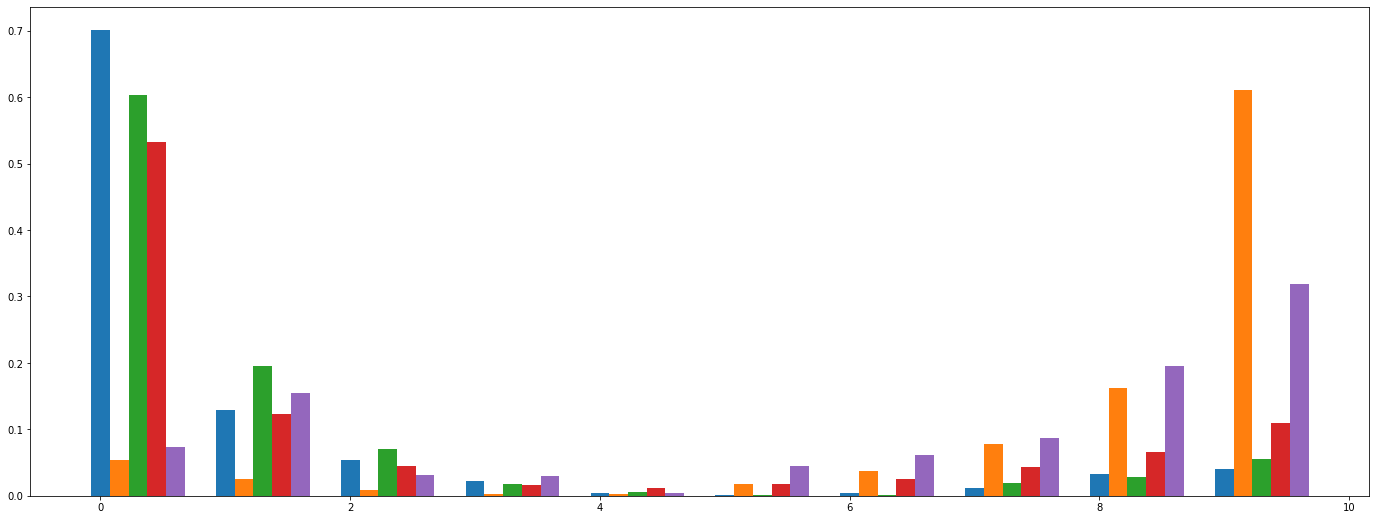

In [15]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (24,9)
xs1 = range(len(A))
barWidth = 0.15
xs2 = [x+barWidth for x in xs1]
xs3 = [x+barWidth for x in xs2]
xs4 = [x+barWidth for x in xs3]
xs5 = [x+barWidth for x in xs4]

plt.bar(xs1, A, width=barWidth)
plt.bar(xs2, B, width=barWidth)
plt.bar(xs3, A0, width=barWidth)
plt.bar(xs4, C0, width=barWidth)
plt.bar(xs5, D0, width=barWidth)


plt.show()

In [27]:
exps = {}
exps[1]= 89
print (exps)


{1: 89}


In [6]:
2323 //100 *100

2300

In [10]:
bincount = 10

a = 3533

binsize = a//bincount

bincount*binsize

3530